# 2D DPP Convergence Study (Conforming Primal)

This notebook runs the 2D convergence study using manufactured solutions and multiple solver strategies, leveraging functions from `perphil.experiments.convergence_2d`. It computes L2 and H1-seminorm errors for the two-pressure formulation and estimates experimental orders of convergence (EOC).

In [1]:
# Imports and project path setup
import sys
from pathlib import Path
import os

os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import firedrake as fd

# perphil imports
from perphil.experiments.convergence_2d import run_one, SolverSpec
from perphil.experiments.iterative_bench import Approach, params_for
from perphil.models.dpp.parameters import DPPParameters
from perphil.utils.postprocessing import (
    calculate_darcy_velocity_from_pressure,
    slice_along_x,
)
from perphil.mesh.builtin import create_mesh
from perphil.forms.spaces import create_function_spaces
from perphil.solvers.solver import solve_dpp
from perphil.solvers.parameters import LINEAR_SOLVER_PARAMS
from perphil.utils.manufactured_solutions import exact_expressions

# Ensure project src is importable (if running the notebook standalone)
repo_root = Path("..").resolve()
src_path = (repo_root / "src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Output directory
out_dir = (repo_root / "notebooks" / "results-conforming-2d").resolve()
out_dir.mkdir(parents=True, exist_ok=True)
print("Output dir:", out_dir)

Output dir: /home/diego/Work/perphil/notebooks/results-conforming-2d


## Error norms: using existing helpers vs firedrake.errornorm

- `perphil.utils.postprocessing` does not define `errornorm`; instead, it provides `l2_error` and `h1_seminorm_error` which assemble the norms directly.
- Firedrake offers `fd.errornorm(u, u_exact, norm_type='L2'|'H1')`. Note that `'H1'` is the full H1 norm; to approximate the seminorm, use `fd.norm(fd.grad(u - u_exact))`.
- In this notebook we’ll stick with `l2_error` and `h1_seminorm_error` for consistency and optionally compare with `fd.errornorm` for a spot check later.

In [2]:
Ns = [4, 8, 16, 32, 64, 128]
degree = 1
quad = True  # set False for triangles

params = DPPParameters()

In [3]:
# Build solver specs aligned with PETSc profiling approaches (skip Picard)
approaches = [
    Approach.PLAIN_GMRES,
    Approach.GMRES_ILU,
    Approach.SS_GMRES,
    Approach.SS_GMRES_ILU,
    Approach.MONOLITHIC_MUMPS,
]

specs = [SolverSpec(name=ap.value, params=params_for(ap)) for ap in approaches]
[spec.name for spec in specs]

['GMRES',
 'GMRES + ILU PC',
 'Scale-Splitting GMRES',
 'Scale-Splitting GMRES + ILU PC',
 'Monolithic LU with MUMPS']

In [4]:
# Smoke test: run a single configuration
try:
    smoke = run_one(N=Ns[0], solver=specs[0], quad=quad, degree=degree, params=params)
    smoke
except Exception as exc:
    print("Smoke test failed:", exc)
    raise

In [5]:
# Batch run across Ns and solver specs
rows = []
for N in Ns:
    for spec in specs:
        try:
            row = run_one(N=N, solver=spec, quad=quad, degree=degree, params=params)
            rows.append(row)
            print(
                f"N={N}, solver={spec.name} -> it={row['it']}, e1_L2={row['e1_L2']:.2e}"
            )
        except Exception as exc:
            print(f"Failed for N={N}, solver={spec.name}: {exc}")


df = pd.DataFrame(rows)
# Ensure numeric types
num_cols = [c for c in df.columns if c not in ("solver",)]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df.sort_values(["solver", "N"], inplace=True)
df.head()

N=4, solver=GMRES -> it=10, e1_L2=1.97e+03
N=4, solver=GMRES + ILU PC -> it=5, e1_L2=1.97e+03
N=4, solver=Scale-Splitting GMRES -> it=4, e1_L2=1.97e+03
N=4, solver=Scale-Splitting GMRES + ILU PC -> it=4, e1_L2=1.97e+03
N=4, solver=Monolithic LU with MUMPS -> it=1, e1_L2=1.97e+03
N=8, solver=GMRES -> it=40, e1_L2=5.88e+02
N=8, solver=GMRES + ILU PC -> it=7, e1_L2=5.88e+02
N=8, solver=Scale-Splitting GMRES -> it=4, e1_L2=5.88e+02
N=8, solver=Scale-Splitting GMRES + ILU PC -> it=4, e1_L2=5.88e+02
N=8, solver=Monolithic LU with MUMPS -> it=1, e1_L2=5.88e+02
N=16, solver=GMRES -> it=292, e1_L2=1.55e+02
N=16, solver=GMRES + ILU PC -> it=11, e1_L2=1.55e+02
N=8, solver=GMRES + ILU PC -> it=7, e1_L2=5.88e+02
N=8, solver=Scale-Splitting GMRES -> it=4, e1_L2=5.88e+02
N=8, solver=Scale-Splitting GMRES + ILU PC -> it=4, e1_L2=5.88e+02
N=8, solver=Monolithic LU with MUMPS -> it=1, e1_L2=5.88e+02
N=16, solver=GMRES -> it=292, e1_L2=1.55e+02
N=16, solver=GMRES + ILU PC -> it=11, e1_L2=1.55e+02
N=16, s

,N,h,degree,quad,solver,it,res,e1_L2,e2_L2,e1_H1s,e2_H1s
0,4,0.250000,1,1,GMRES,10,3.107972e-07,1965.737537,196572.595487,30018.893180,3.001857e+06
5,8,0.125000,1,1,GMRES,40,3.795447e-04,587.648403,58764.671469,17608.612542,1.760849e+06
10,16,0.062500,1,1,GMRES,292,1.167512e-03,154.912078,15491.168221,9247.823724,9.247771e+05
15,32,0.031250,1,1,GMRES,996,1.871848e-03,39.265111,3926.494846,4684.615342,4.684590e+05
20,64,0.015625,1,1,GMRES,3307,2.719896e-03,9.850528,985.023469,2350.076312,2.350064e+05


In [6]:
# Compute EOC per solver using linear regression on log(h) vs log(error)


def compute_eoc(df, err_col):
    eoc_rows = []
    for solver, g in df.groupby("solver"):
        g = g.dropna(subset=["h", err_col]).sort_values("h")
        if len(g) >= 2 and (g[err_col] > 0).all():
            x = np.log(g["h"].values)
            y = np.log(g[err_col].values)
            slope, intercept = np.polyfit(x, y, 1)
            eoc_rows.append({"solver": solver, "err": err_col, "slope": slope})
    return pd.DataFrame(eoc_rows)


errs = ["e1_L2", "e2_L2", "e1_H1s", "e2_H1s"]
eoc_tables = [compute_eoc(df, e) for e in errs]
eoc_df = pd.concat(eoc_tables, ignore_index=True)
# For convergence, slope ~ degree+1 for L2 and ~ degree for H1-seminorm. Negative slopes indicate decreasing error with h.
eoc_df

,solver,err,slope
0,GMRES,e1_L2,1.939170
1,GMRES + ILU PC,e1_L2,1.938957
2,Monolithic LU with MUMPS,e1_L2,1.939236
3,Scale-Splitting GMRES,e1_L2,1.939280
4,Scale-Splitting GMRES + ILU PC,e1_L2,1.939275
5,GMRES,e2_L2,1.939247
6,GMRES + ILU PC,e2_L2,1.939234
7,Monolithic LU with MUMPS,e2_L2,1.939235
8,Scale-Splitting GMRES,e2_L2,1.939235
9,Scale-Splitting GMRES + ILU PC,e2_L2,1.939235


Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/convergence_curves.png


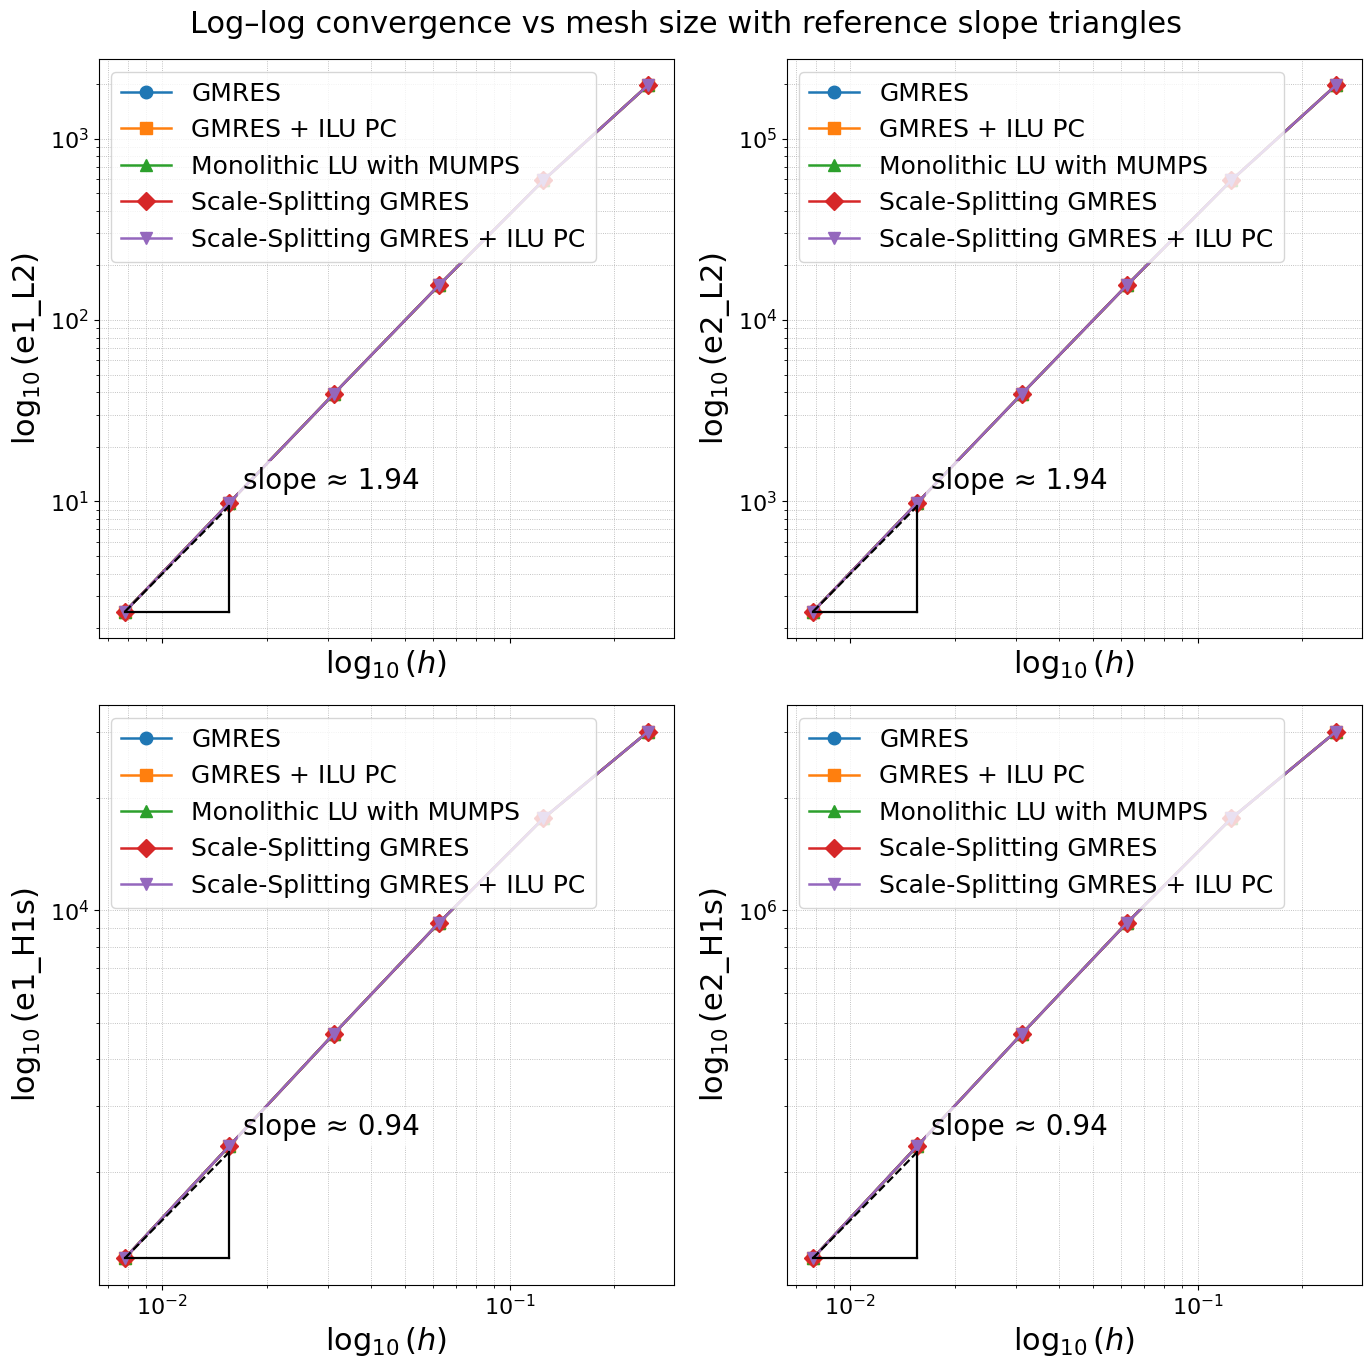

In [7]:
# Plot L2 and H1-seminorm convergence with reference slope triangles (bigger, clearer)
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=False)
ax_map = {
    "e1_L2": axes[0, 0],
    "e2_L2": axes[0, 1],
    "e1_H1s": axes[1, 0],
    "e2_H1s": axes[1, 1],
}

marker_size = 9
line_width = 1.8
tri_line_width = 1.6
markers = ["o", "s", "^", "D", "v", ">"]
solver_list = list(df["solver"].unique())

# Helper to add a slope triangle on log-log axes


def add_slope_triangle(ax, x0, y0, slope, factor=2.0, color="k"):
    """Draw a right triangle on log-log axes indicating a slope.
    - x0, y0: anchor (lower-left vertex)
    - slope: target slope in log-log (order of convergence)
    - factor: horizontal size multiplier (>1)
    """
    x1 = x0 * factor
    y1 = y0 * (factor**slope)
    # Horizontal leg
    ax.plot([x0, x1], [y0, y0], color=color, lw=tri_line_width, zorder=5)
    # Vertical leg
    ax.plot([x1, x1], [y0, y1], color=color, lw=tri_line_width, zorder=5)
    # Hypotenuse
    ax.plot([x0, x1], [y0, y1], color=color, lw=tri_line_width, ls="--", zorder=5)
    # Label near the hypotenuse end with a slight screen-space offset
    ax.annotate(
        f"slope ≈ {slope:.2f}",
        xy=(x1, y1),
        xycoords="data",
        xytext=(10, 8),
        textcoords="offset points",
        fontsize=20,
        color=color,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )


# Build a dict for quick slope lookup: slopes[(err, solver)] -> value
slopes = {}
for _, r in eoc_df.iterrows():
    slopes[(r["err"], r["solver"])] = (
        float(r["slope"]) if pd.notnull(r["slope"]) else None
    )

for err, ax in ax_map.items():
    for i, (solver, g) in enumerate(df.groupby("solver")):
        g = g.dropna(subset=["h", err]).sort_values("h")
        if len(g) == 0:
            continue
        ax.loglog(
            g["h"],
            g[err],
            marker=markers[i % len(markers)],
            markersize=marker_size,
            linewidth=line_width,
            label=solver,
        )

    ax.set_xlabel(r"$\log_{10}(h)$")
    ax.set_ylabel(rf"$\log_{{10}}$({err})")
    ax.grid(True, which="both", ls=":", lw=0.6)
    ax.legend(fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.tick_params(axis="both", which="minor", labelsize=11)

    # Add a reference slope triangle for the first available solver in this subplot
    # Prefer the first solver in solver_list with valid data and slope
    for solver in solver_list:
        g = df[df["solver"] == solver].dropna(subset=["h", err]).sort_values("h")
        s = slopes.get((err, solver), None)
        if len(g) >= 2 and s is not None:
            # Anchor near the smallest h (left) but ensure triangle fits inside current h-range
            x0 = g["h"].iloc[0]
            y0 = max(g[err].min(), 1e-300)  # avoid zero
            max_h = g["h"].iloc[-1]
            factor = 2.0
            if x0 * factor > max_h:
                factor = max(1.2, (max_h / x0) * 0.9)
            add_slope_triangle(ax, x0, y0, slope=abs(s), factor=factor, color="k")
            break  # one triangle per subplot is enough

fig.suptitle(
    "Log–log convergence vs mesh size with reference slope triangles", fontsize=22
)
fig.tight_layout()
fig.savefig(out_dir / "convergence_curves.png", dpi=200)
print("Saved:", out_dir / "convergence_curves.png")
plt.show()

In [8]:
# Save CSV results
df_path = out_dir / "convergence.csv"
eoc_path = out_dir / "convergence_eoc.csv"

df.to_csv(df_path, index=False)
eoc_df.to_csv(eoc_path, index=False)

print("Saved:", df_path)
print("Saved:", eoc_path)

df.head()

Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/convergence.csv
Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/convergence_eoc.csv


,N,h,degree,quad,solver,it,res,e1_L2,e2_L2,e1_H1s,e2_H1s
0,4,0.250000,1,1,GMRES,10,3.107972e-07,1965.737537,196572.595487,30018.893180,3.001857e+06
5,8,0.125000,1,1,GMRES,40,3.795447e-04,587.648403,58764.671469,17608.612542,1.760849e+06
10,16,0.062500,1,1,GMRES,292,1.167512e-03,154.912078,15491.168221,9247.823724,9.247771e+05
15,32,0.031250,1,1,GMRES,996,1.871848e-03,39.265111,3926.494846,4684.615342,4.684590e+05
20,64,0.015625,1,1,GMRES,3307,2.719896e-03,9.850528,985.023469,2350.076312,2.350064e+05


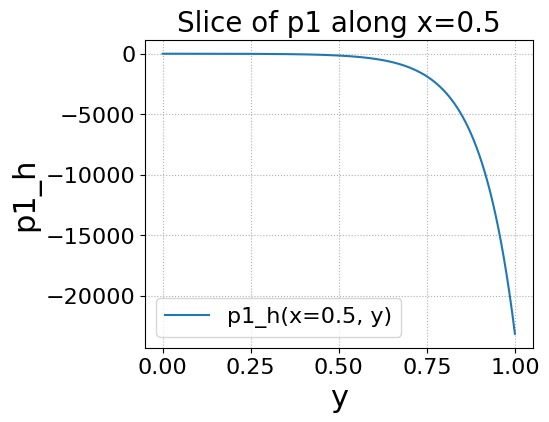

In [9]:
# Optional: Postprocessing demo on a single run (velocity and slice)
N_demo = Ns[-1]
mesh = create_mesh(N_demo, N_demo, quadrilateral=quad)
_, V_demo = create_function_spaces(mesh, pressure_deg=degree, pressure_family="CG")
W_demo = fd.MixedFunctionSpace((V_demo, V_demo))

# Exact pressures for BCs
_, p1_exact_expr, _, p2_exact_expr = exact_expressions(mesh, params)

bcs_demo = [
    fd.DirichletBC(W_demo.sub(0), p1_exact_expr, "on_boundary"),
    fd.DirichletBC(W_demo.sub(1), p2_exact_expr, "on_boundary"),
]

# Solve with direct solver for a clean reference
sol_demo = solve_dpp(
    W_demo, params, bcs=bcs_demo, solver_parameters=LINEAR_SOLVER_PARAMS
)

p1_h = sol_demo.solution.sub(0)
p2_h = sol_demo.solution.sub(1)

# Darcy velocity from p1
u1_h = calculate_darcy_velocity_from_pressure(p1_h, params.k1 / params.mu, degree=1)

# Slice along x=0.5
ys, vals = slice_along_x(p1_h, x_value=0.5)

plt.figure(figsize=(5, 4))
plt.plot(ys, vals, label="p1_h(x=0.5, y)")
plt.xlabel("y")
plt.ylabel("p1_h")
plt.grid(True, ls=":")
plt.legend()
plt.title("Slice of p1 along x=0.5")
plt.show()